In [33]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [34]:
#Locate image data
data_root = 'images/train_set'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root)

Found 220 images belonging to 8 classes.


In [35]:
#get pretrained classifier
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/3'
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [36]:
#Image data
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 220 images belonging to 8 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


In [37]:
#Create model
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False
model = tf.keras.Sequential([
    features_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 18:47:52.749872 4443583936 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 10248     
Total params: 10,248
Trainable params: 10,248
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Intialize training session
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

In [39]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [41]:
#Train
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=10, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/10
6/6 [==============================] - 4s 704ms/step - loss: 2.2169 - acc: 0.1649
Epoch 2/10
6/6 [==============================] - 4s 607ms/step - loss: 1.8118 - acc: 0.3750
Epoch 3/10
6/6 [==============================] - 4s 614ms/step - loss: 1.4523 - acc: 0.5266
Epoch 4/10
6/6 [==============================] - 4s 597ms/step - loss: 1.1307 - acc: 0.6915
Epoch 5/10
6/6 [==============================] - 4s 596ms/step - loss: 0.9148 - acc: 0.7447
Epoch 6/10
6/6 [==============================] - 4s 593ms/step - loss: 0.8233 - acc: 0.7926
Epoch 7/10
6/6 [==============================] - 4s 590ms/step - loss: 0.6231 - acc: 0.8989
Epoch 8/10
6/6 [==============================] - 4s 591ms/step - loss: 0.5485 - acc: 0.9202
Epoch 9/10
6/6 [==============================] - 4s 603ms/step - loss: 0.4625 - acc: 0.9167
Epoch 10/10
6/6 [==============================] - 4s 591ms/step - loss: 0.4011 - acc: 0.9574


In [42]:
#Get label names
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Ahagon_Umiko', 'Hazuki_Shizuku', 'Lijima_Yun', 'Sakura_Nene',
       'Suzukaze_Aoba', 'Takimoto_Hifumi', 'Toyama_Rin', 'Yagami_Kou'],
      dtype='<U15')

In [43]:
#Get predictions
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Takimoto_Hifumi', 'Sakura_Nene', 'Ahagon_Umiko', 'Yagami_Kou',
       'Takimoto_Hifumi', 'Takimoto_Hifumi', 'Hazuki_Shizuku',
       'Yagami_Kou', 'Suzukaze_Aoba', 'Suzukaze_Aoba', 'Takimoto_Hifumi',
       'Yagami_Kou', 'Lijima_Yun', 'Suzukaze_Aoba', 'Takimoto_Hifumi',
       'Sakura_Nene', 'Lijima_Yun', 'Suzukaze_Aoba', 'Takimoto_Hifumi',
       'Suzukaze_Aoba', 'Lijima_Yun', 'Lijima_Yun', 'Lijima_Yun',
       'Takimoto_Hifumi', 'Lijima_Yun', 'Takimoto_Hifumi', 'Yagami_Kou',
       'Yagami_Kou', 'Takimoto_Hifumi', 'Sakura_Nene', 'Suzukaze_Aoba',
       'Sakura_Nene'], dtype='<U15')

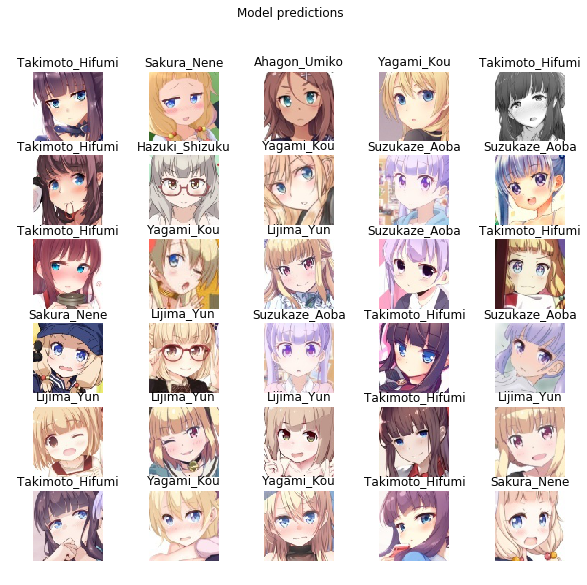

In [44]:
#Visualize predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [45]:
#Save model
if not os.path.exists('models'):
    os.makedirs('models')
saver = tf.train.Saver()
saver.save(sess, 'models/my_model')

'models/my_model'

In [46]:
#Testing the model

#Locate test images
data_root = 'images/test_set'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root)

Found 52 images belonging to 8 classes.


In [47]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 52 images belonging to 8 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


In [48]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Yagami_Kou', 'Yagami_Kou', 'Takimoto_Hifumi', 'Lijima_Yun',
       'Lijima_Yun', 'Ahagon_Umiko', 'Sakura_Nene', 'Sakura_Nene',
       'Sakura_Nene', 'Yagami_Kou', 'Yagami_Kou', 'Lijima_Yun',
       'Yagami_Kou', 'Suzukaze_Aoba', 'Lijima_Yun', 'Ahagon_Umiko',
       'Takimoto_Hifumi', 'Takimoto_Hifumi', 'Takimoto_Hifumi',
       'Lijima_Yun', 'Suzukaze_Aoba', 'Takimoto_Hifumi',
       'Takimoto_Hifumi', 'Lijima_Yun', 'Suzukaze_Aoba', 'Lijima_Yun',
       'Suzukaze_Aoba', 'Lijima_Yun', 'Suzukaze_Aoba', 'Lijima_Yun',
       'Ahagon_Umiko', 'Yagami_Kou'], dtype='<U15')

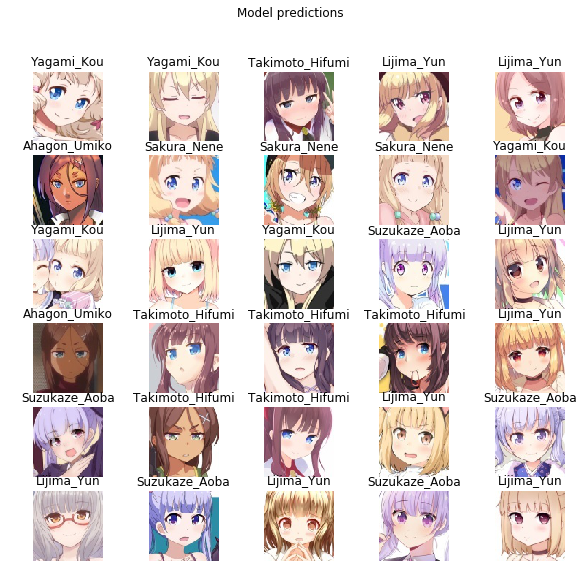

In [49]:
#Visualize predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [50]:
#Accuracy of test set
prediction_indices = []
for arr in result_batch:
    prediction_indices.append(arr.tolist().index(max(arr)))
label_indices = []
for arr in label_batch:
    label_indices.append(arr.tolist().index(max(arr)))
same_count = 0
for i in np.arange(len(prediction_indices)):
    if prediction_indices[i] == label_indices[i]:
        same_count += 1
accuracy = same_count/len(prediction_indices)
print(accuracy)

0.8125
